<a href="https://colab.research.google.com/github/gromag/Gym-NeuralNetwork/blob/dgans-experiments/Gym%208%20-%20GANs/Learner%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Deepfakes with Keras

![DCGAN](https://github.com/gromag/Gym-NeuralNetwork/blob/master/Gym%208%20-%20GANs/DCGAN.png?raw=1)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib inline

In [2]:
!pip3 install tensorflow==2.7.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-3e6t_alh
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-3e6t_alh
  Created wheel for tfutils: filename=tfutils-0.0.1-py3-none-any.whl size=6454 sha256=319ad605e051766a33a0b5abe2c25a1451a123f645fc11c06e142b9b81af094c
  Stored in directory: /tmp/pip-ephem-wheel-cache-nob2yuke/wheels/76/26/c1/59c11d1b3edc8644c22d4251d283ce58f43ca5e99eb08268ad
Successfully built tfutils


In [4]:
# %matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


# Task 2: Importing and Plotting the Data

In [30]:
32 * 32

1024

(5923, 784)


TypeError: ignored

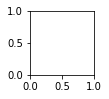

In [38]:
x = x_train/256
print(x_train.shape)

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i], cmap="coolwarm")

In [26]:
def load_data(one_hot=True):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
    print(x_train.shape)
    size = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
    x_train = np.reshape(x_train, (x_train.shape[0], size))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], size))/255.
    y_train = np.reshape(y_train, (y_train.shape[0]))
    y_test = np.reshape(y_test, (y_test.shape[0]))
    if one_hot:
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

In [14]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)
print(x_train.shape)
print(x_test.shape)
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train[:10])

(60000, 784)
(10000, 784)
(5923, 784)
(980, 784)
[5 0 4 1 9 2 1 3 1 4]


In [48]:
def load_subset(classes, x, y):
    """
    y should not be one hot encoded
    """
    x_subset = None
    for i, c in enumerate(classes):
        indices = np.squeeze(np.where(y == c))
        x_c = x[indices]
        if i == 0:
            x_subset = np.array(x_c)
        else:
            x_subset = np.concatenate([x_subset, x_c], axis=0)
    return x_subset

In [59]:
(x_train, y_train), (x_test, y_test) = load_data(one_hot=False)
i = np.squeeze(np.where(y_train == 0))
i
y_train[i]


(50000, 32, 32, 3)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
x_train = load_subset([0], x_train, y_train)
x_test = load_subset([0], x_test, y_test)
print(x_train.shape)
print(x_test.shape)
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

(500, 3072)
[[0.71372549 0.69803922 0.74117647 ... 0.72156863 0.72156863 0.72156863]
 [0.54509804 0.3254902  0.27843137 ... 0.91764706 0.76470588 0.59215686]
 [0.95294118 0.94901961 0.98039216 ... 0.94509804 0.94117647 0.96470588]
 ...
 [0.08235294 0.09803922 0.04705882 ... 0.14117647 0.18039216 0.10588235]
 [0.23529412 0.17647059 0.19607843 ... 0.73333333 0.71372549 0.62745098]
 [0.66666667 0.79215686 0.51764706 ... 0.83921569 0.49803922 0.52156863]]


In [51]:
def plot_ten_random_examples(plt, x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10, replace=False)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((32, 32, 3)), cmap='coolwarm')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

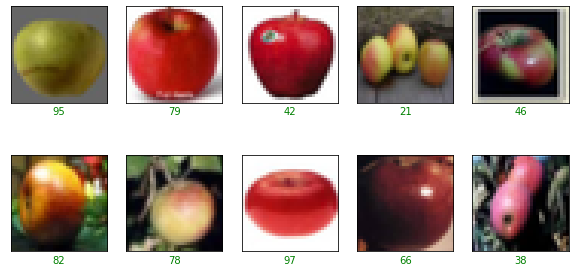

In [52]:
plot_ten_random_examples(plt, x, y).show()

# Task 3: Discriminator

![Artist and Critic](https://github.com/gromag/Gym-NeuralNetwork/blob/master/Gym%208%20-%20GANs/artist_critic.png?raw=1)

In [ ]:
discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28,28,1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 256)        

# Task 4: Generator

In [ ]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4, activation='sigmoid')
])

generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_20 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_21 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


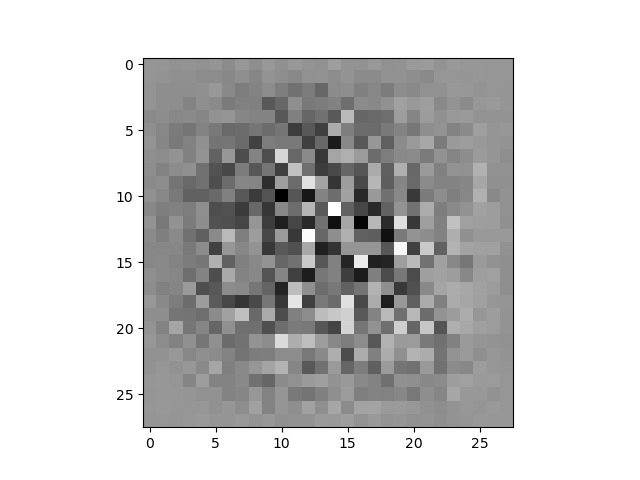

In [ ]:
noise = np.random.randn(1,1)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [ ]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)

Steps per epoch= 107


<IPython.core.display.Javascript object>


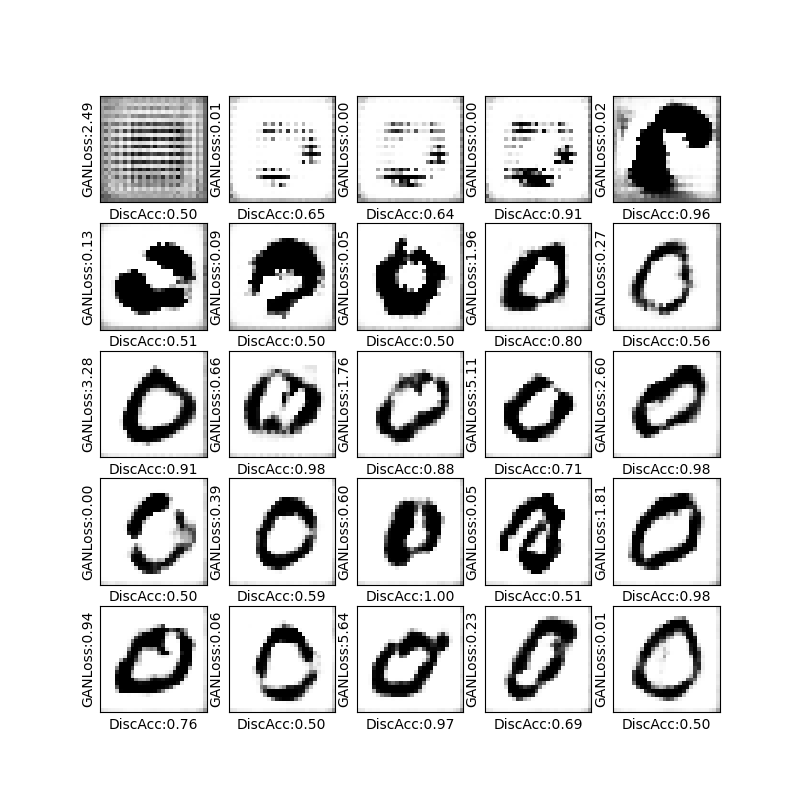

In [ ]:
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True        
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        
        _,acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28, 28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))
    